### Library import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import math
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (6,6)

#
from sklearn.model_selection import train_test_split


#---- CNN model libraries ----
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import callbacks
from keras import backend as K
from keras.models import load_model

In [2]:
def get_distance(p1, p2):
    """
    Description: Function to return the Eucledian distance between 2 points
    Input: p1: First point with coordinates x1,y1
            p2: Second point with coordinates x2,y2
    Output: Eucleadian distance between p1 and p2
    """
    x2 = p2[0]
    x1 = p1[0]
    y2 = p2[1]
    y1 = p1[1]
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return dist

In [3]:
#Define metric functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
def get_detection_accuracy(real_obj, predicted_obj):
    #constant. Max possible detection range of the system
    max_range = 1.54
    temp_acc = []
    #for  every real object
    for object_to_evaluate in real_obj:
        temp_dist = []
        #if no predicted objects, return accuracy of 0
        if len(predicted_obj) == 0:
            temp_acc.append(0)
        else:
            #for every predicted object
            for object_to_compare in predicted_obj:
                #get the distance between real object and predicted objects
                temp_dist.append(get_distance(df_coords.iloc[object_to_evaluate,:].values,
                                             df_coords.iloc[object_to_compare,:].values))
            #keep the min distance     
            min_temp_dist = min(temp_dist)
            #calculate the accuracy for the given object
            temp_acc.append(1.0 - min_temp_dist/max_range)
    
    #calculate the overall detection accuracy using the distances
    distance_accuracy = sum(temp_acc)/len(temp_acc)
    #calculate the overall detection accuracy using the number of detected objects
    number_accuracy = 1 - (np.abs(len(predicted_obj)-len(real_obj))/len(real_obj))
    #average of the two accuracy values
    overall_accuracy = (distance_accuracy + number_accuracy) / 2

    return overall_accuracy

### Dataset import

In [5]:
df_features = pd.read_csv('datasets/features_3.csv')
df_labels = pd.read_csv('datasets/labels_3.csv')
df_coords = pd.read_csv('datasets/coords.csv')
print('Feature Dataset shape: ', df_features.shape)
print('\nLabels Dataset shape:', df_labels.shape)

Feature Dataset shape:  (17066, 243)

Labels Dataset shape: (17066, 161)


Separate dataset into train/test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_features.iloc[:,:].values,
                                                    df_labels.iloc[:,:].values,
                                                    test_size = 0.25,
                                                    random_state = 0)

### Model architecture

#### Catboost classifier model

In [8]:
from catboost import CatBoostClassifier

In [11]:
cat_features = list(range(0, X_train.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [17]:
y_train.shape

(12799, 161)

In [16]:
clf = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

clf.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

TypeError: unhashable type: 'numpy.ndarray'

#### Neural net classifier

In [27]:
classifier =  Sequential()

#Hidden layer 1 - Input layer
classifier.add( Dense(units = df_features.shape[1], kernel_initializer = 'he_uniform', activation = 'relu') )

#Hidden layer 2
classifier.add( Dense(units = 15, kernel_initializer = 'he_uniform', activation = 'relu') )

#Output layer
classifier.add( Dense(units = df_labels.shape[1], activation = 'sigmoid') )

In [28]:
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-08
decay = 0.0
epochs = 50

opt = keras.optimizers.Adam(lr=learning_rate,decay=learning_rate/epochs)

In [29]:
#opt = SGD(lr=0.01, momentum=0.9)
classifier.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', f1_m])

In [30]:
#ANN training 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)


history = classifier.fit(X_train, y_train,
                         epochs = epochs,
                         batch_size = 32,
                        validation_data=(X_test, y_test),
                        callbacks =[earlystopping])

Epoch 1/50
400/400 [==============================] - 6s 13ms/step - loss: 0.2803 - accuracy: 0.0126 - f1_m: 0.0143 - val_loss: 0.1050 - val_accuracy: 0.0337 - val_f1_m: 0.0000e+00
Epoch 2/50
400/400 [==============================] - 5s 13ms/step - loss: 0.1017 - accuracy: 0.0337 - f1_m: 0.0000e+00 - val_loss: 0.0930 - val_accuracy: 0.0471 - val_f1_m: 0.0000e+00
Epoch 3/50
400/400 [==============================] - 4s 11ms/step - loss: 0.0896 - accuracy: 0.0520 - f1_m: 8.7517e-04 - val_loss: 0.0828 - val_accuracy: 0.0562 - val_f1_m: 0.0087
Epoch 4/50
400/400 [==============================] - 4s 11ms/step - loss: 0.0798 - accuracy: 0.0668 - f1_m: 0.0152 - val_loss: 0.0773 - val_accuracy: 0.0696 - val_f1_m: 0.0305
Epoch 5/50
400/400 [==============================] - 5s 13ms/step - loss: 0.0753 - accuracy: 0.0855 - f1_m: 0.0355 - val_loss: 0.0742 - val_accuracy: 0.0783 - val_f1_m: 0.0408
Epoch 6/50
400/400 [==============================] - 6s 15ms/step - loss: 0.0718 - accuracy: 0.095

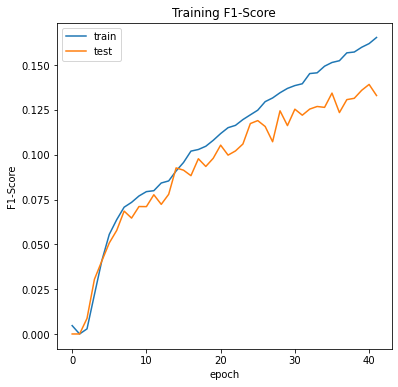

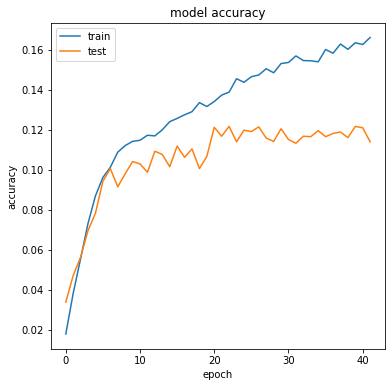

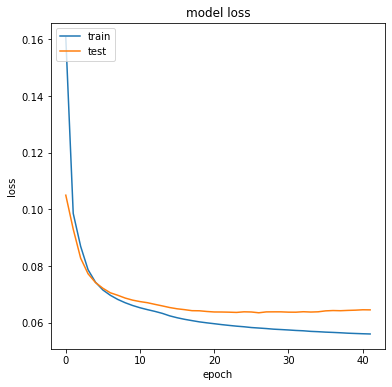

In [31]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Training F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#f1-score
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Neural net classifier

In [7]:
df_features.shape[1]

243

In [46]:
classifier =  Sequential()

#Hidden layer 1 - Input layer
classifier.add( Dense(units = df_features.shape[1], kernel_initializer = 'he_uniform', activation = 'relu') )

#Hidden layer 3
classifier.add( Dense(units = 128, kernel_initializer = 'he_uniform', activation = 'relu') )
#Hidden layer 4
classifier.add( Dense(units = 90, kernel_initializer = 'he_uniform', activation = 'relu') )
#Hidden layer 5
classifier.add( Dense(units = 128, kernel_initializer = 'he_uniform', activation = 'relu') )


#Output layer
classifier.add( Dense(units = df_labels.shape[1], activation = 'sigmoid') )

Optimizer setup

In [47]:
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-08
decay = 0.0
epochs = 50

opt = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=learning_rate/epochs)

CNN compile using the Adam optimizer and Binary crossentropy as loss function and accuracy as main metric.

In [48]:
#opt = SGD(lr=0.01, momentum=0.9)
classifier.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', f1_m])

In [49]:
#ANN training 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)


history = classifier.fit(X_train, y_train,
                         epochs = epochs,
                         batch_size = 20,
                        validation_data=(X_test, y_test),
                        callbacks =[earlystopping])

Epoch 1/50
640/640 [==============================] - 11s 16ms/step - loss: 0.1584 - accuracy: 0.0212 - f1_m: 0.0061 - val_loss: 0.0755 - val_accuracy: 0.0691 - val_f1_m: 0.0321
Epoch 2/50
640/640 [==============================] - 8s 13ms/step - loss: 0.0710 - accuracy: 0.0928 - f1_m: 0.0628 - val_loss: 0.0665 - val_accuracy: 0.0961 - val_f1_m: 0.1084
Epoch 3/50
640/640 [==============================] - 8s 12ms/step - loss: 0.0625 - accuracy: 0.1208 - f1_m: 0.1290 - val_loss: 0.0632 - val_accuracy: 0.1169 - val_f1_m: 0.1286
Epoch 4/50
640/640 [==============================] - 10s 16ms/step - loss: 0.0587 - accuracy: 0.1517 - f1_m: 0.1713 - val_loss: 0.0618 - val_accuracy: 0.1373 - val_f1_m: 0.1626
Epoch 5/50
640/640 [==============================] - 8s 13ms/step - loss: 0.0560 - accuracy: 0.1668 - f1_m: 0.2125 - val_loss: 0.0612 - val_accuracy: 0.1397 - val_f1_m: 0.1553
Epoch 6/50
640/640 [==============================] - 9s 14ms/step - loss: 0.0541 - accuracy: 0.1758 - f1_m: 0.23

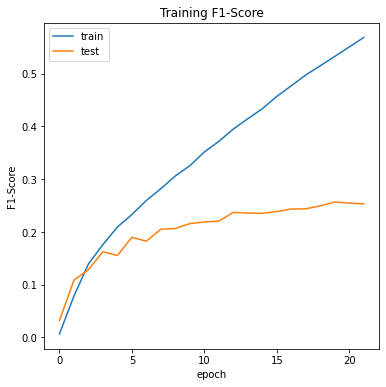

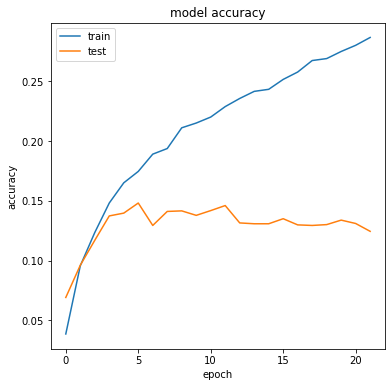

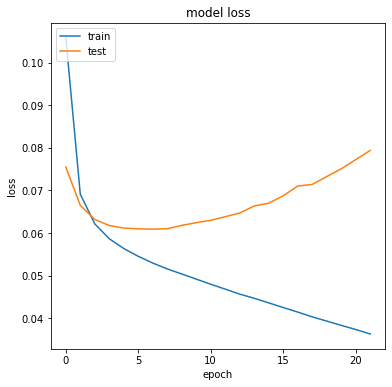

In [50]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Training F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#f1-score
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

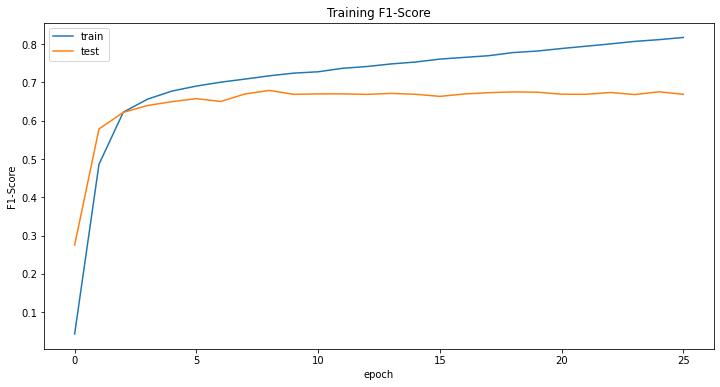

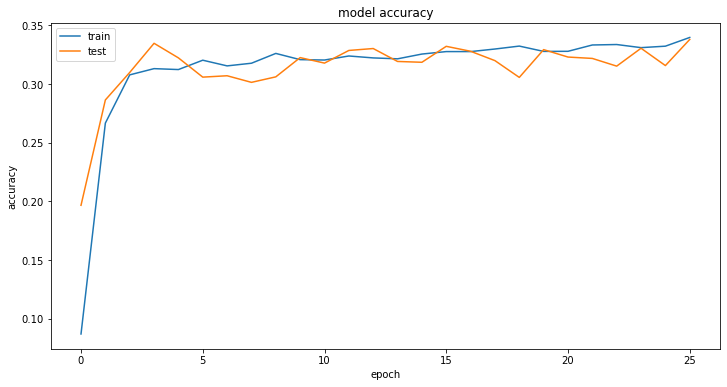

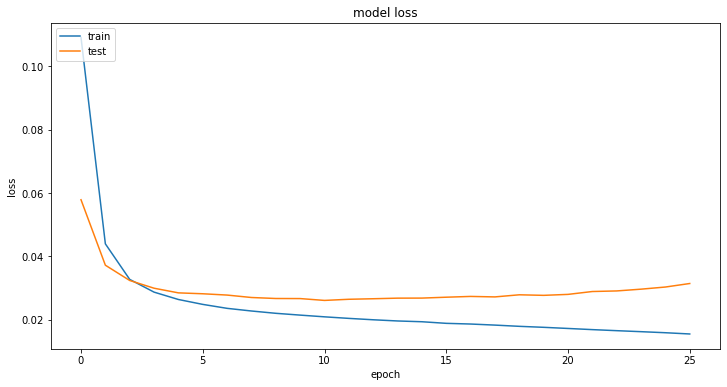

In [46]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Training F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#f1-score
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save/load model

In [20]:
#save trained model to the following path
path_to_save = 'models/model_v2.h5'
classifier.save(path_to_save)

In [6]:
#load model from path
path_to_load = 'models/model_v2.h5'
#define needed dependecies to load the model
dependencies = {
    'f1_m': f1_m
}
#load the model
classifier = load_model(path_to_load, custom_objects=dependencies)

2022-10-04 12:19:32.110445: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-04 12:19:32.111118: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 12:19:32.112885: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Predictions - Validation data

In [12]:
df_val_features = pd.read_csv('datasets/test_features.csv')
df_val_labels = pd.read_csv('datasets/test_labels.csv')

In [13]:
X_val = df_val_features.iloc[:,:].values
y_val = df_val_labels.iloc[:,:].values

In [14]:
#define a threshold value 
threshold = 0.4
#ANN prediction
y_pred = classifier.predict(X_val)
#keep predictions above the threshold
y_pred = (y_pred > threshold)

In [20]:
validation_accuracy = []
for prediction_index in range(len(y_pred)):
    #load the predicted and real quadrants for the test dataset
    predicted_quadrant = np.argwhere(np.isin(y_pred[prediction_index], True)).ravel()
    real_quadrant = np.argwhere(np.isin(y_val[prediction_index], True)).ravel()
    
    prediction_accuracy = get_detection_accuracy(real_obj= real_quadrant,
                                                 predicted_obj= predicted_quadrant)
    validation_accuracy.append(prediction_accuracy)
print('Overall accuracy: ', sum(validation_accuracy)/len(validation_accuracy))

Overall accuracy:  0.6961037922077922


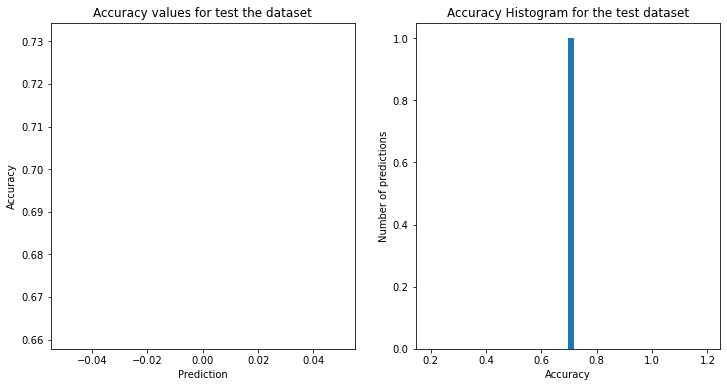

In [21]:
plt.rcParams["figure.figsize"] = (12,6)

plt.subplot(1,2,1)
plt.title('Accuracy values for test the dataset')
plt.plot(list(range(y_pred.shape[0])),
                     validation_accuracy, color = 'orange')
plt.xlabel('Prediction')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.title('Accuracy Histogram for the test dataset')
plt.xlabel('Accuracy')
plt.ylabel('Number of predictions')
plt.hist(validation_accuracy, bins=50)
plt.show()

In [22]:
index = 0

print('Real object quadrant: ',
      np.argwhere(np.isin(y_val[index], True)).ravel())
print('\nPredicted object quadrant: ',
      np.argwhere(np.isin(y_pred[index], True)).ravel())

Real object quadrant:  [ 0 17 42 68 92]

Predicted object quadrant:  [ 0  1 17 18 19 42 43 68]


### Predictions - test dataset

In [11]:
#define a threshold value 
threshold = 0.40
#ANN prediction
y_pred = classifier.predict(X_test)
#keep predictions above the threshold
y_pred = (y_pred > threshold)

NameError: name 'X_test' is not defined

In [21]:
index = 1011

print('Real object quadrant: ',
      np.argwhere(np.isin(y_test[index], True)).ravel())
print('\nPredicted object quadrant: ',
      np.argwhere(np.isin(y_pred[index], True)).ravel())

Real object quadrant:  [ 48 129]

Predicted object quadrant:  [ 48 108]


In [22]:
test_accuracy = []
for prediction_index in range(len(y_pred)):
    #load the predicted and real quadrants for the test dataset
    predicted_quadrant = np.argwhere(np.isin(y_pred[prediction_index], True)).ravel()
    real_quadrant = np.argwhere(np.isin(y_test[prediction_index], True)).ravel()
    
    prediction_accuracy = get_detection_accuracy(real_obj= real_quadrant,
                                                 predicted_obj= predicted_quadrant)
    test_accuracy.append(prediction_accuracy)
print('Overall accuracy: ', sum(test_accuracy)/len(test_accuracy))

Overall accuracy:  0.8564663940692905


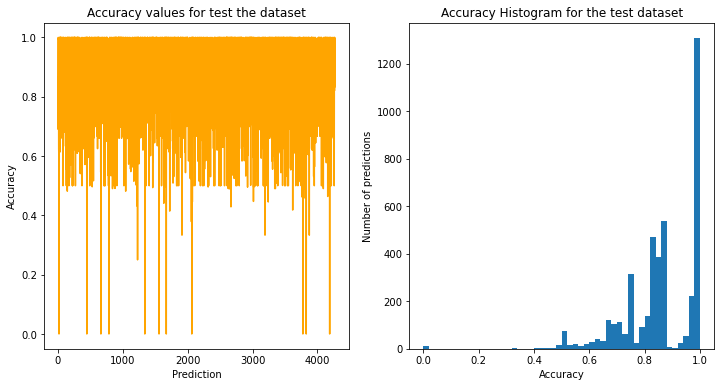

In [23]:
plt.rcParams["figure.figsize"] = (12,6)

plt.subplot(1,2,1)
plt.title('Accuracy values for test the dataset')
plt.plot(list(range(y_pred.shape[0])),
                     test_accuracy, color = 'orange')
plt.xlabel('Prediction')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.title('Accuracy Histogram for the test dataset')
plt.xlabel('Accuracy')
plt.ylabel('Number of predictions')
plt.hist(test_accuracy, bins=50)
plt.show()

In [39]:
index = 3827

print('Real object quadrant: ',
      np.argwhere(np.isin(y_test[index], True)).ravel())
print('\nPredicted object quadrant: ',
      np.argwhere(np.isin(y_pred[index], True)).ravel())

Real object quadrant:  [ 39  43  69 113]

Predicted object quadrant:  []


In [36]:
#get all the indexes of the predictions that belongs to the same accuracy number -> target accuracy
target_acc = 0
indexes = [i for i,x in enumerate(test_accuracy) if x == target_acc]
indexes

[15, 444, 661, 785, 1338, 1557, 1669, 2062, 3775, 3827, 4188]